# 1.0 Import Packages

In [3]:
import tensorflow as tf
import keras.api._v2.keras as keras
import os
import cv2 
import imghdr
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# 2.0 Processing Images

In [6]:
# load file directory
data_dir = 'Concrete-Crack-Images'

In [7]:
# set image file type to process
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# 3.0 Load Dataset

In [10]:
# load the dataset
data = keras.utils.image_dataset_from_directory(data_dir)

Found 40000 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

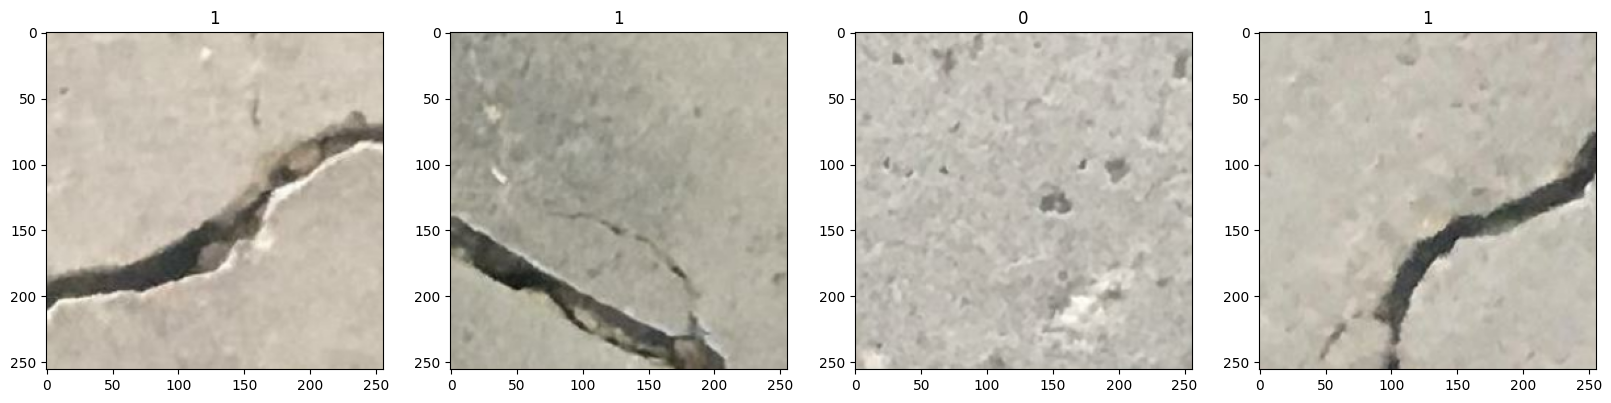

In [13]:
# visualize images class
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4.0 Scaling Dataset

In [14]:
# scaling the data using map
data = data.map(lambda x,y: (x/255,y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.44313726, 0.43529412, 0.3882353 ],
          [0.43988204, 0.4320389 , 0.38498008],
          [0.4364047 , 0.42856157, 0.38150275],
          ...,
          [0.49411765, 0.47843137, 0.43137255],
          [0.4934513 , 0.47776502, 0.4307062 ],
          [0.49019608, 0.4745098 , 0.42745098]],
 
         [[0.4626685 , 0.45482537, 0.40776655],
          [0.4594133 , 0.45157015, 0.40451133],
          [0.4582693 , 0.45042616, 0.40336734],
          ...,
          [0.50062805, 0.48494178, 0.43788296],
          [0.4999617 , 0.48427543, 0.4372166 ],
          [0.4967065 , 0.4810202 , 0.4339614 ]],
 
         [[0.47791055, 0.4700674 , 0.4230086 ],
          [0.47698867, 0.46914554, 0.42208672],
          [0.47478506, 0.46694192, 0.4198831 ],
          ...,
          [0.50477177, 0.48908547, 0.44202664],
          [0.504583  , 0.48889676, 0.44183794],
          [0.50366116, 0.48797488, 0.44091606]],
 
         ...,
 
         [[0.48960632, 0.47392005, 0.4307828 ],
          [0.48635

# 5.0 Splitting Dataset

In [16]:
# splitting data with length of dataset
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) # for tuning parameters like number of hidden layers
test_size = int(len(data)*.1) # solely for getting the performance of the model

In [17]:
# assign to new var for the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6.0 Building DL Model

In [20]:
# using Sequential() for create model
model = Sequential()

In [21]:
# adding layers to the model
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
# compile the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
# show summary of the model
model.summary() # to see the overall structure of our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

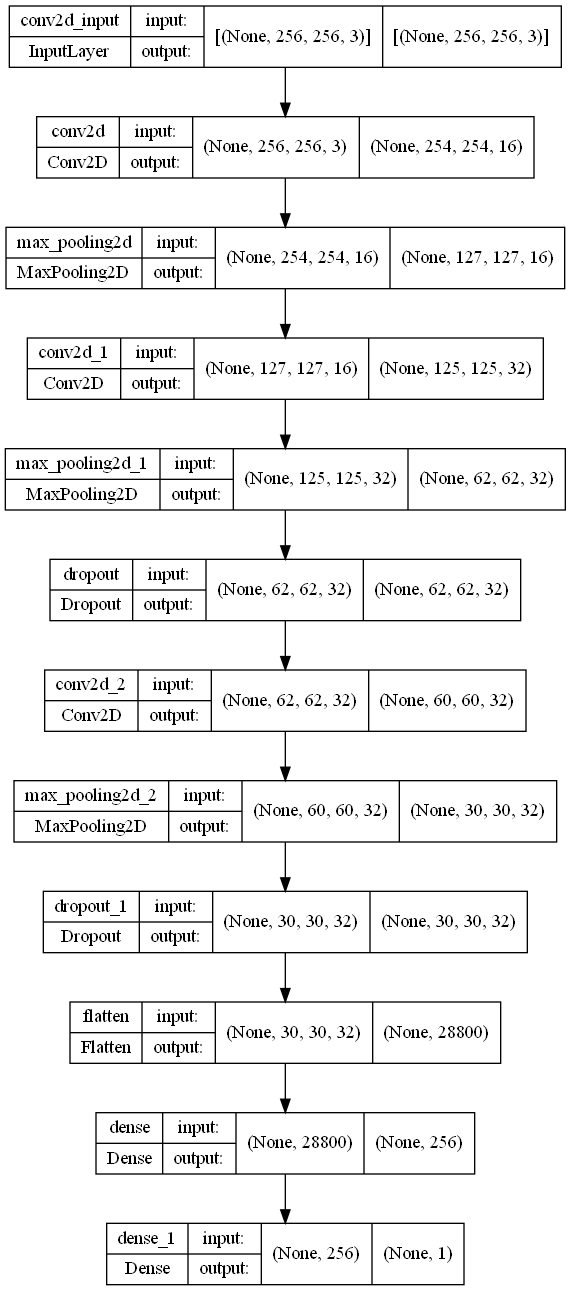

In [51]:
# plot model architecture and save it to directory

plot_model(model, to_file='model_architecture.png', show_shapes=True)

# 7.0 Trainning the Model

In [24]:
# define log path
logdir = 'logs'

In [25]:
# create tensorboard
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
# create early stopping
erls = tf.keras.callbacks.EarlyStopping(patience=2)
#monitor='loss'

In [29]:
# train the model
hist = model.fit(train, batch_size=100, epochs=3, validation_data=val, callbacks=[erls, tensorboard_callback])

Epoch 1/3
875/875 [==============================] - 1842s 2s/step - loss: 0.1847 - accuracy: 0.9188 - val_loss: 0.0479 - val_accuracy: 0.9869
Epoch 2/3
875/875 [==============================] - 1775s 2s/step - loss: 0.0609 - accuracy: 0.9827 - val_loss: 0.0297 - val_accuracy: 0.9900
Epoch 3/3
875/875 [==============================] - 1778s 2s/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0423 - val_accuracy: 0.9837


# 8.0 Plot Performance

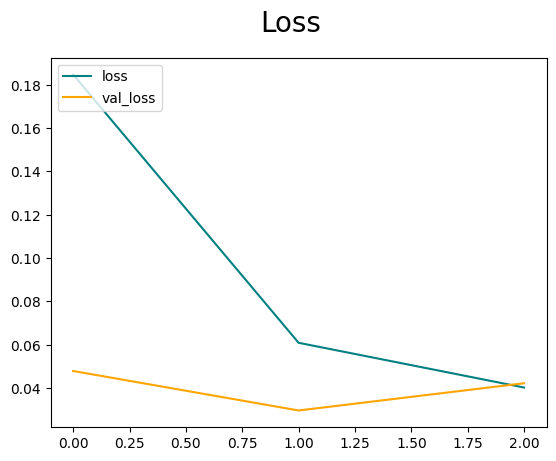

In [30]:
# plotting performance for loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

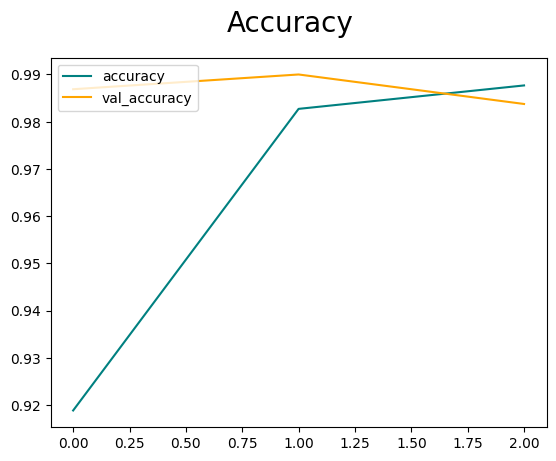

In [31]:
# plotting performance for accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 9.0 Evaluate the Model

In [33]:
# evaluate model for precision, recall and accuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    pred = model.predict(X)
    pre.update_state(y, pred)
    re.update_state(y,pred)
    acc.update_state(y, pred)

In [47]:
# results for precision, recall and accuracy
res_pre = pre.result().numpy()
res_rec = re.result().numpy()
res_acc = acc.result().numpy()

print('Precision: ', res_pre)
print('Recall: ', res_rec)
print('Accuracy: ', res_acc)

Precision:  0.9989791
Recall:  0.96881187
Accuracy:  0.98375


# 10.0 Testing the Model with other images

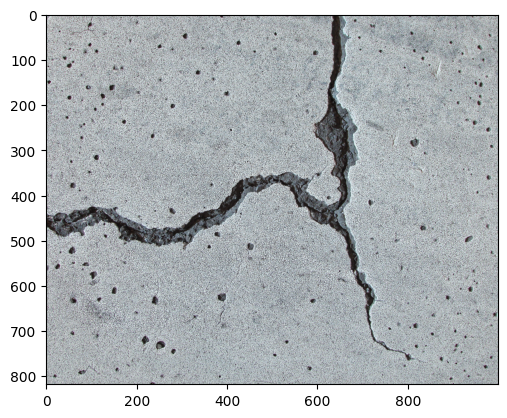

In [42]:
# read image from the directory
img = cv2.imread('concrete1.jpg')
plt.imshow(img)
plt.show()

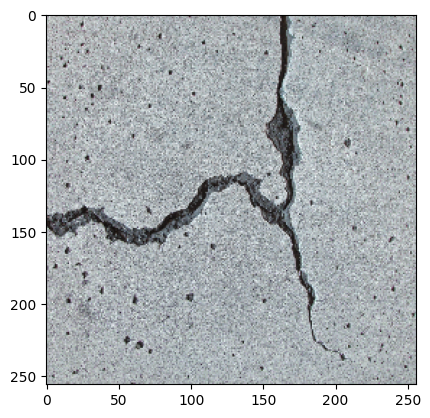

In [43]:
# resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
# predict the model output of the image
y_pred = model.predict(np.expand_dims(resize/255,0))

In [45]:
y_pred

array([[1.]], dtype=float32)

In [46]:
# resulst of the model prediction for the classes
if y_pred > 0.5:
    print(f'Predicted Class: Concrete Cracked')
else:
    print(f'Predicted Class: Concrete No Crack')

Predicted Class: Concrete Cracked


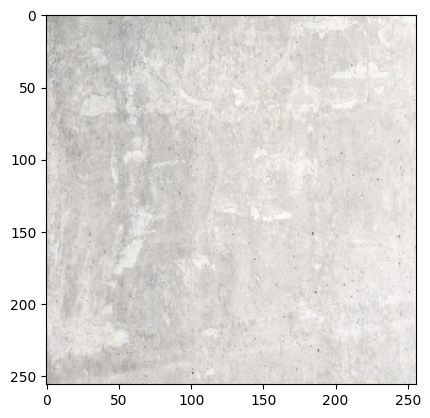

In [48]:
# second image
img1 = cv2.imread('concrete0.jpg')

# resize the image
resize1 = tf.image.resize(img1, (256,256))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [49]:
# predict the model output of the image
y_pred1 = model.predict(np.expand_dims(resize1/255,0))

In [50]:
# resulst of the model prediction for the classes
if y_pred1 > 0.5:
    print(f'Predicted Class: Concrete Cracked')
else:
    print(f'Predicted Class: Concrete No Crack')

Predicted Class: Concrete No Crack


# 11.0 Save the Model

In [52]:
model.save(os.path.join('models', 'model_imgclass.h5'))

# 12.0 Deploy Model to make Prediction

In [177]:
# load saved model
#from tensorflow.keras.models import load_model
#load_model = load_model('./models/model_imgclass.h5')

In [ ]:
# # select image to be predict the class
# img = cv2.imread('concrete0.jpg')

# # resize the selected image and show
# resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype(int))
# plt.show()

In [178]:
# make predictions for the selected image
# y_pred = load_model.predict(np.expand_dims(resize/255,0))

In [179]:
# # resulst of the model prediction for the classes
# if y_pred1 > 0.5:
#     print(f'Predicted Class: Concrete Cracked')
# else:
#     print(f'Predicted Class: Concrete No Crack')